# Classifier analysis

In this notebook we compare the performance between the classifier trained on F2305 and the one which was trained purely on sythetic data.

In [1]:
import torchvision
import torch 
import copy
from torch.utils.data import DataLoader 
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt     
import numpy as np
import os
import sys
import pgan

import warnings
warnings.filterwarnings('ignore')

gpu = torch.cuda.is_available()
if gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
    
if os.path.basename(os.getcwd()) != 'BDI-imaging':  # change dir to ROOT
    os.chdir("../../")
sys.path.insert(0, "src")
print('============ Demo information ============')
print('- Working directory: /{}'.format('/'.join(os.getcwd().split('/')[-2:])))
print('- Cuda device: {}'.format(device))
print('==========================================')


from manuscript.Train.test_dataset import A2209Dataset, A2209Batcher

============ Demo information ============
- Working directory: /BDI-imaging/src
- Cuda device: cpu


#### Load network and weights

In [2]:
net = torchvision.models.resnet18(pretrained=False)
# modify input layer from 3 to 9 channels
net.conv1 = torch.nn.Conv2d(9, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# modify output classes from 1000 to 3
net.fc = torch.nn.Linear(in_features=512, out_features=3, bias=True)

In [3]:
net_f2305 = net
net_synth = copy.deepcopy(net)

ckpt_f2305 = "manuscript/Diversity/classifier_logs/f2305/bs_32_lr_0.0001_transform_False/classifier_weights.ckpt"
ckpt_f2305 = torch.load(ckpt_f2305, map_location=torch.device('cpu'))
net_f2305.load_state_dict(ckpt_f2305["model"])

ckpt_synth = "manuscript/Diversity/classifier_logs/synth/bs_32_lr_0.0001_transform_False/classifier_weights.ckpt"
ckpt_synth = torch.load(ckpt_synth, map_location=torch.device('cpu'))
net_synth.load_state_dict(ckpt_synth["model"])

<All keys matched successfully>

#### Load A2209

In [4]:
testdata = A2209Dataset(shape=(9, 64, 64))
testdata.prepare(label_by="berlin_clinical", types=('T1',))
vu_loader_test = DataLoader(A2209Batcher(testdata.dataset, testdata.scan_path), batch_size=32, shuffle=False)

## Metrics

(In the following we load the predictions and labels from the checkpoint directly.)

### Balanced accuracy

In [5]:
from sklearn.metrics import balanced_accuracy_score

print(" Trained on real:",balanced_accuracy_score(ckpt_f2305["labs_vu"], ckpt_f2305["preds_vu"]), "\n",
"Trained on synthetic:", balanced_accuracy_score(ckpt_synth["labs_vu"], ckpt_synth["preds_vu"]))

 Trained on real: 0.8932019212673165 
 Trained on synthetic: 0.8297014998649876


### Confusion Matrix

In [6]:
from sklearn.metrics import confusion_matrix

cm_real = confusion_matrix(ckpt_f2305["labs_vu"], ckpt_f2305["preds_vu"])
cm_synth = confusion_matrix(ckpt_synth["labs_vu"], ckpt_synth["preds_vu"])
cm_real_norm = confusion_matrix(ckpt_f2305["labs_vu"], ckpt_f2305["preds_vu"], normalize="all")
cm_synth_norm = confusion_matrix(ckpt_synth["labs_vu"], ckpt_synth["preds_vu"], normalize="all")

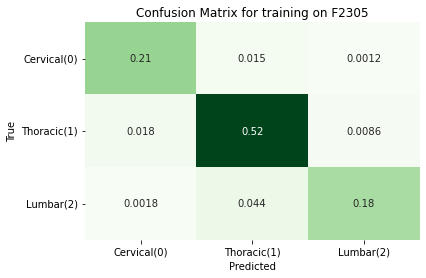

In [7]:
import seaborn as sn

ax= plt.subplot()
sn.heatmap(cm_real_norm, annot=True, ax = ax, cmap="Greens", cbar=False); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted');ax.set_ylabel('True')
ax.set_title('Confusion Matrix for training on F2305')
ax.xaxis.set_ticklabels(["Cervical(0)", "Thoracic(1)", "Lumbar(2)"])
plt.yticks(np.arange(3)+0.5,("Cervical(0)", "Thoracic(1)", "Lumbar(2)"), rotation=0, fontsize="10", va="center")
plt.savefig('../src/manuscript/Diversity/images/train_classifier_confusion.png', dpi=300, bbox='tight')

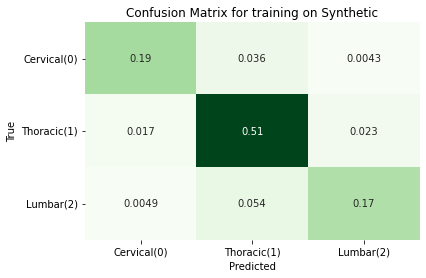

In [8]:
ax= plt.subplot()
sn.heatmap(cm_synth_norm, annot=True, ax = ax, cmap="Greens", cbar=False); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted');ax.set_ylabel('True')
ax.set_title('Confusion Matrix for training on Synthetic')
ax.xaxis.set_ticklabels(["Cervical(0)", "Thoracic(1)", "Lumbar(2)"])
plt.yticks(np.arange(3)+0.5,("Cervical(0)", "Thoracic(1)", "Lumbar(2)"), rotation=0, fontsize="10", va="center")
plt.savefig('../src/manuscript/Diversity/images/synthetic_classifier_confusion.png', dpi=300, bbox='tight')

In [9]:
#Reference
np.unique(ckpt_f2305["labs_vu"], return_counts=True)[1]/np.unique(ckpt_f2305["labs_vu"], return_counts=True)[1].sum()

array([0.22584615, 0.54646154, 0.22769231])

### ROC

To compute the multi-class ROC we treat each classification as a binary problem. Reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [11]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

def plot_roc(labs, softs, include_macro=False, include_micro=False,
             labels = ["Cervical", "Thoracic", "Lumbar"], title = "ROC", save_name=None):
    # from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    
    one_hot = torch.nn.functional.one_hot(labs)
    n_classes = 3
    lw = 2 #line width for plot

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(one_hot[:,i], softs[: ,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(one_hot.view(-1), softs.view(-1))
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    
    if include_micro:
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)
    if include_macro:
        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(labels[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    if save_name is not None:
        plt.savefig(save_name, dpi=300, bbox='tight')
    plt.show()


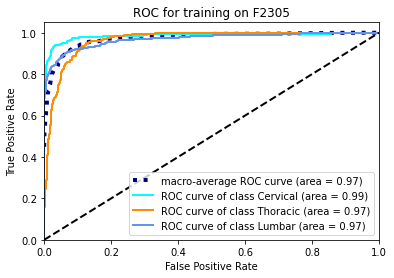

In [12]:
save_name = '../src/manuscript/Diversity/images/synthetic_classifier_ROC.png'
plot_roc(ckpt_f2305["labs_vu"],ckpt_f2305["softs_vu"],include_macro=True,
         title="ROC for training on F2305", save_name=save_name)

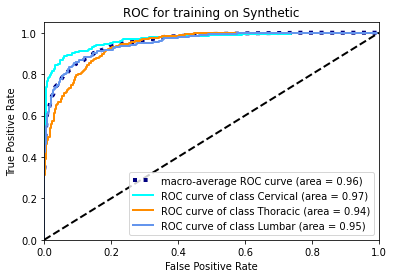

In [13]:
save_name = '../src/manuscript/Diversity/images/train_classifier_ROC.png'
plot_roc(ckpt_synth["labs_vu"],ckpt_synth["softs_vu"],include_macro=True,
         title="ROC for training on Synthetic", save_name=save_name)